In [46]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)
from combiners import EpochsCombiner
from typing import *
import mne
import tensorflow as tf
import mneflow as mf
import matplotlib.pyplot as plt
import numpy as np
from utils.data_management import dict2str
from lfcnn_vis import plot_patterns
from LFCNN_decoder import SpatialParameters, TemporalParameters, ComponentsOrder, Predictions, WaveForms
import pickle
from utils.machine_learning import one_hot_decoder
import sklearn.metrics as sm
from utils.machine_learning.confusion import ConfusionEstimator
import scipy as sp
import pylustrator
from PIL import Image
from dataclasses import dataclass
from copy import deepcopy
import mne

@dataclass
class InducedsComparer(object):
    induced_cond_1: np.ndarray
    induced_cond_2: np.ndarray
    ratio: float
    meta: Any = None

    def diff(self, normalize=False, absolute=False):
        if normalize:
            induced_cond_1 = normal_rows(self.induced_cond_1)
            induced_cond_2 = normal_rows(self.induced_cond_2)
        else:
            induced_cond_1 = self.induced_cond_1
            induced_cond_2 = self.induced_cond_2

        diff = np.abs(induced_cond_1 - induced_cond_2) if absolute else induced_cond_1 - induced_cond_2

        return diff/(induced_cond_1 + induced_cond_2)

    def normalize(self):
        self.induced_cond_1 = normal_rows(self.induced_cond_1)
        self.induced_cond_2 = normal_rows(self.induced_cond_2)

    def copy(self):
        return deepcopy(self)

def normal_rows(matrix, inplace=False):
    if not inplace:
        matrix = matrix.copy()

    for i, row in enumerate(matrix):
        matrix[i] = row/row.mean()

    return matrix if not inplace else None

def compare(x1 :np.array, x2: np.array) -> float:
    return (x1@x2)/(np.linalg.norm(x1)*np.linalg.norm(x2))

def binary_mask(matrix, ratio=1):
    return np.ma.make_mask(matrix > ratio*matrix.mean())

def read_pkl(path: str) -> Any:
    with open(
            path,
            'rb'
        ) as file:
        content = pickle.load(
            file
        )
    return content

def draw_inddif(induced1, induced2, tf, savepath=False, title1='B1-B3', title2='Diff', title3='B10-B12', suptitle=''):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
    ax1.imshow(
        induced1,
        cmap='RdBu_r',
        origin='lower'
    )
    ax1.set_title(title1)
    ax2.imshow(
        tf,
        cmap='RdBu_r',
        origin='lower'
    )
    ax2.set_title(title2)
    ax3.imshow(
        induced2,
        cmap='RdBu_r',
        origin='lower'
    )
    ax3.set_title(title3)
    w, h = 15, 5
    fig.suptitle(suptitle)
    fig.set_size_inches(w, h)
    if savepath:
        plt.savefig(savepath, dpi=300)
        plt.close()
    else:
        plt.show()

def mimshow(*args: np.ndarray, titles=None, suptitle='', axis=0):
    if not titles:
        titles = ['' for _ in args]
    if len(args) != len(titles):
        titles = titles + ['' for _ in len(args) - len(titles)]
    fig, axes = plt.subplots(ncols=len(args)) if axis == 0 else plt.subplots(nrows=len(args))
    for content, ax, title in zip(args, axes, titles):
        ax.imshow(
            content,
            cmap='RdBu_r',
            origin='lower'
        )
        ax.set_title(title)

    fig.suptitle(suptitle)

    return fig

0.7294149703450135
Az_Mar 0.22044318105077046
Fe_To 0.24729181457375402
Ga_Fed 0.8847639729144692
Ku_EL 3.3569737976469874e-05
Pr_An 0.06462210173941309
Ru_Ek 0.7986891676610175
Se_Tu 0.0012095039008130984
Te_Ali 0.20432671879042794
0.5249118386479802
Az_Mar 0.7987730944102072
Fe_To 0.06992779924281035
Ga_Fed 0.8976579938416056
Ku_EL 0.010412073501413184
Pr_An 0.009809250593320364
Ru_Ek 0.16655462846679903
Se_Tu 0.5599172090095405
Te_Ali 0.20128319597924627
0.3754040952866827
Az_Mar 0.4139227001106274
Fe_To 0.5288057957882868
Ga_Fed 0.1436337908943724
Ku_EL 0.00016155895130067735
Pr_An 0.525977508560308
Ru_Ek 0.8112986618258529
Se_Tu 0.42150280715505484


/tmp/ipykernel_30119/3445156736.py:112: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=len(args)) if axis == 0 else plt.subplots(nrows=len(args))


Te_Ali 0.007062897614629757
0.7577555731219194
Az_Mar 0.32830662587766757
Fe_To 0.8772404681818446
Ga_Fed 0.5147033910496341
Ku_EL 0.2069686823874456
Pr_An 0.9179278903558445
Ru_Ek 0.0591530802517096
Se_Tu 0.18324536831467225
Te_Ali 0.36860298807502334


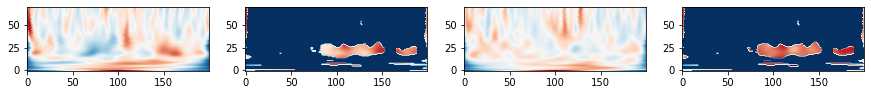

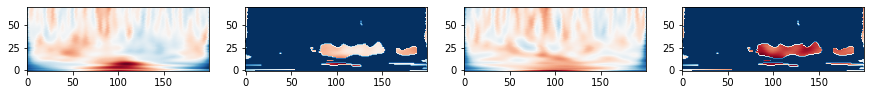

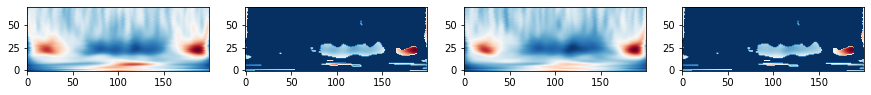

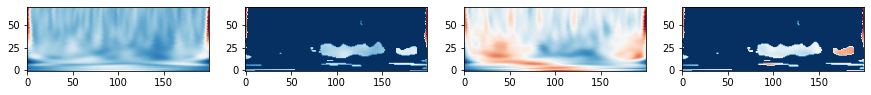

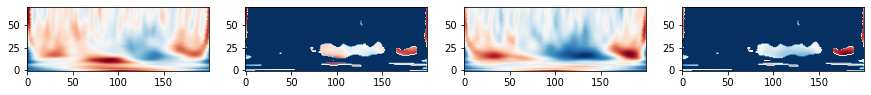

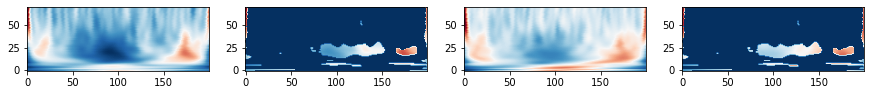

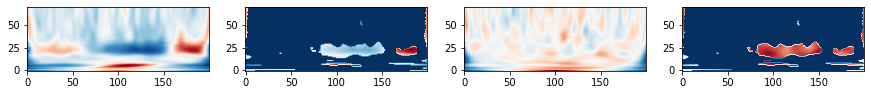

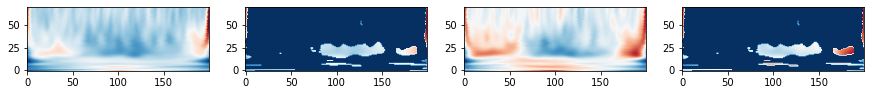

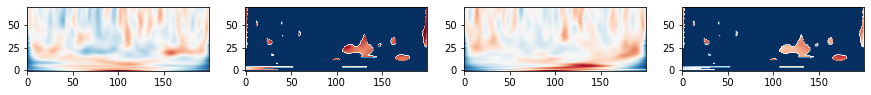

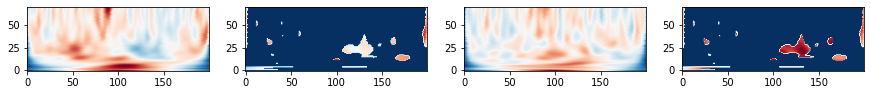

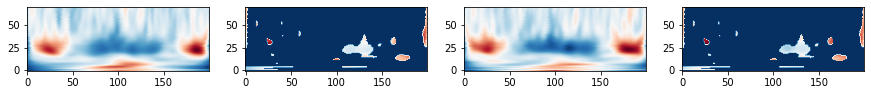

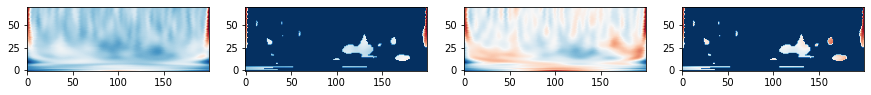

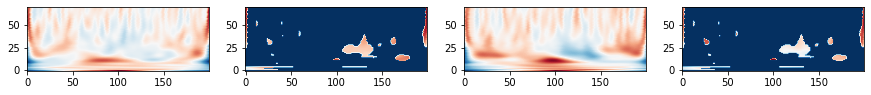

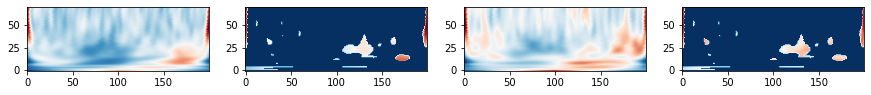

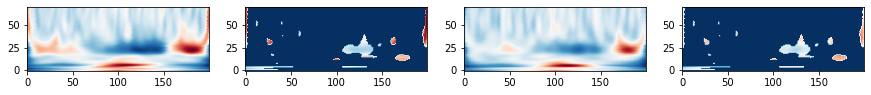

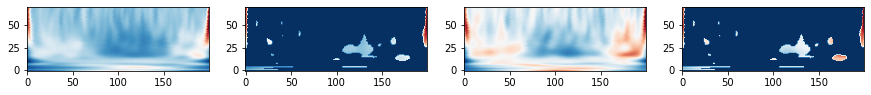

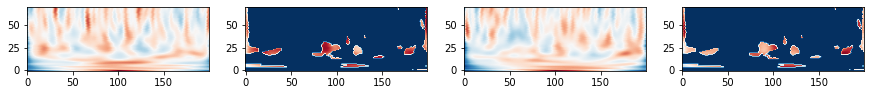

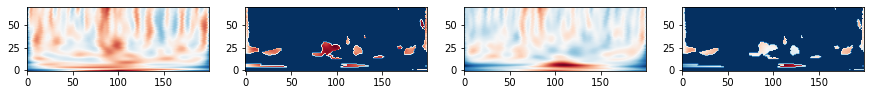

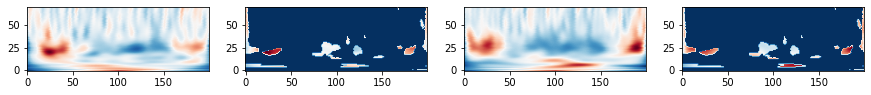

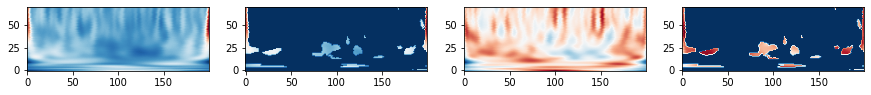

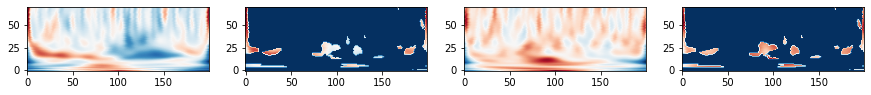

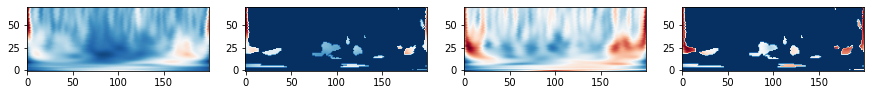

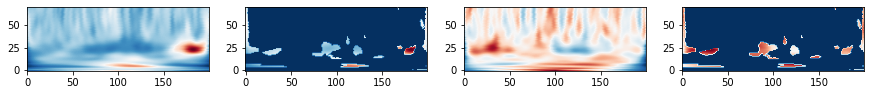

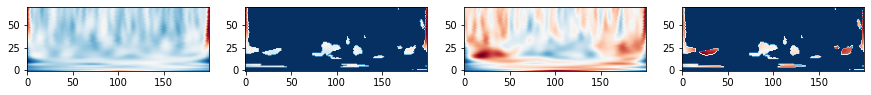

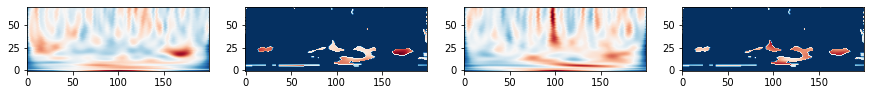

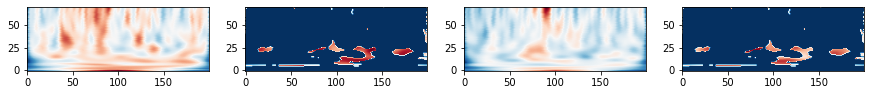

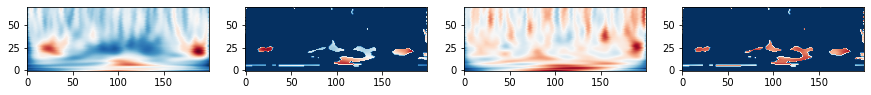

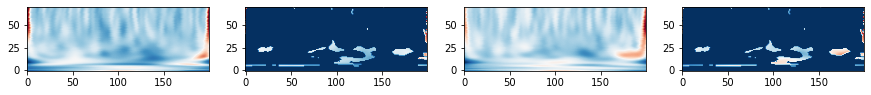

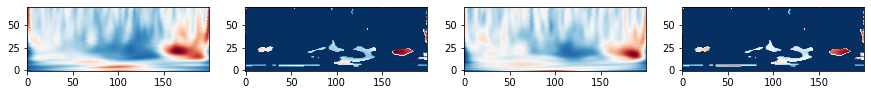

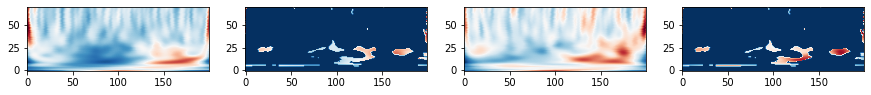

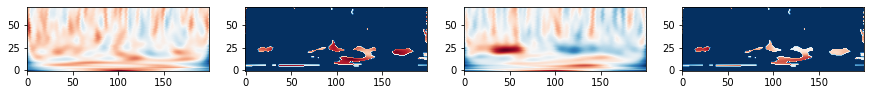

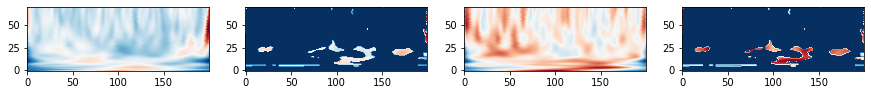

In [62]:
subjects_dir = os.path.join('../', 'Source', 'Subjects')

for cases_to_combine in [
    ['LM LI', 'RM RI'],
    ['LM', 'LI', 'RM', 'RI'],
    ['LM', 'LI'],
    ['RM', 'RI']
]:
    classification_name,\
        classification_postfix,\
        classification_prefix = None, '', ''
    cases_to_combine = [case.split(' ') for case in cases_to_combine]
    cases_to_combine = sorted(cases_to_combine, reverse=True)
    class_names = ['&'.join(sorted(cases_combination, reverse=True)) for cases_combination in cases_to_combine]

    if classification_name is None:
        classification_name = '_vs_'.join(class_names)

    classification_name_formatted = "_".join(list(filter(lambda s: s not in (None, ""), [classification_prefix, classification_name, classification_postfix])))

    tfs = list()
    induceds1 = list()
    induceds2 = list()
    induceds = list()
    for subject_name in os.listdir(subjects_dir):

        if subject_name == 'Pse_Udo':
            continue

        ses = 'B1-B3'
        model = f'LFCNN_train_{ses}'
        subject_parameters_path = os.path.join(subjects_dir, subject_name, model, 'Parameters')
        waveforms1 = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_waveforms.pkl'))
        spatial_parameters1 = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_spatial.pkl'))
        ses = 'B10-B12'
        model = f'LFCNN_train_{ses}'
        subject_parameters_path = os.path.join(subjects_dir, subject_name, model, 'Parameters')
        waveforms2 = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_waveforms.pkl'))
        spatial_parameters2 = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_spatial.pkl'))
        patterns = spatial_parameters1.patterns

        indices1 = list(
            map(
                lambda item: item[0],
                sorted(
                    enumerate(spatial_parameters1.patterns.T),
                    key=lambda item: np.abs(item[1]).sum(0),
                    reverse=True
                )
            )
        )

        pair_found = False
        pat_i = 0
        while not pair_found:
            best_pattern_index = indices1[pat_i]
            best_pattern = patterns[:, best_pattern_index]

            indices2 = list(
                map(
                    lambda item: item[0],
                    sorted(
                        enumerate(spatial_parameters2.patterns.T),
                        key=lambda item: compare(best_pattern, item[1]),
                        reverse=True
                    )
                )
            )
            ratio = compare(best_pattern, spatial_parameters2.patterns[:, indices2[0]])
            if ratio >= .75:
                pair_found = True
            else:
                pat_i += 1

        induced1 = waveforms1.induced[indices1[pat_i], :, :]
        induced2 = waveforms2.induced[indices1[pat_i], :, :]

        induceds.append(InducedsComparer(
            induced1,
            induced2,
            ratio,
            dict(subject_name = subject_name)
        ))
        # draw_inddif(
        #     induceds[-1].induced_cond_1,
        #     induceds[-1].induced_cond_2,
        #     induceds[-1].diff(normalize=True, absolute=True),
        #     title3=f'B10-B12, {induceds[-1].ratio}',
        #     suptitle=subject_name
        # )
    induced_ave_1 = np.array([induced.induced_cond_1 for induced in induceds]).mean(0)
    induced_ave_2 = np.array([induced.induced_cond_2 for induced in induceds]).mean(0)
    diff_ave_abs = np.array([induced.diff(normalize=True, absolute=True) for induced in induceds]).mean(0)
    # draw_inddif(
    #     normal_rows(induced_ave_1),
    #     normal_rows(induced_ave_2),
    #     diff_ave_abs
    # )
    # draw_inddif(
    #     normal_rows(induced_ave_1),
    #     normal_rows(induced_ave_2),
    #     binary_mask(diff_ave_abs, 1.5)
    # )
    mask = binary_mask(diff_ave_abs, 1.5)
    induced_ave_cropped_cond_1 = np.reshape(mask*normal_rows(induced_ave_1), -1)
    induced_ave_cropped_cond_1[induced_ave_cropped_cond_1 != 0]
    induced_ave_cropped_cond_2 = np.reshape(mask*normal_rows(induced_ave_2), -1)
    induced_ave_cropped_cond_2[induced_ave_cropped_cond_2 != 0]
    s, p = sp.stats.ttest_ind(induced_ave_cropped_cond_1, induced_ave_cropped_cond_2)
    print(p)

    T_obs, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_test(
        # subjects x time x freq
        [normal_rows(induced_ave_1), normal_rows(induced_ave_2)],
        tail=0,
        out_type='mask',
        verbose=False,
        # stat_fun=lambda x, y: sp.stats.ttest_rel(x, y)[-1]
    )
    print(clusters)

    # for p, cluster in zip(cluster_pv, clusters):
    #     if p < .1:
    #         cluster = np.ma.make_mask(cluster)
    #         print(cluster)
    #         fig = mimshow(
    #             normal_rows(induced_ave_1),
    #             cluster*normal_rows(induced_ave_1),
    #             normal_rows(induced_ave_2),
    #             cluster*normal_rows(induced_ave_2)
    #         )
    #         w, h = 15, 5
    #         fig.set_size_inches(w, h)

    for indcomp in induceds:
        fig = mimshow(
            normal_rows(indcomp.induced_cond_1),
            mask*normal_rows(indcomp.induced_cond_1),
            normal_rows(indcomp.induced_cond_2),
            mask*normal_rows(indcomp.induced_cond_2)
        )
        w, h = 15, 5
        fig.set_size_inches(w, h)
        ind_cropped_cond_1 = np.reshape(mask*normal_rows(indcomp.induced_cond_1), -1)
        ind_cropped_cond_2 = np.reshape(mask*normal_rows(indcomp.induced_cond_2), -1)
        ind_cropped_cond_1[ind_cropped_cond_1 != 0]
        ind_cropped_cond_2[ind_cropped_cond_2 != 0]
        # print(ind_cropped_cond_2.shape)
        s, p = sp.stats.ttest_ind(ind_cropped_cond_1, ind_cropped_cond_2)
        print(indcomp.meta['subject_name'], p)
